In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

In [6]:
db = pd.read_csv("my-data/output.csv")
db.head()

,run,database,workload,record_nbr,type,label,value
0,r1,Redis,workload a,"1,000",overall,RunTime(ms),1064.000
1,r1,Redis,workload a,"1,000",overall,Throughput(ops/sec),939.840
2,r1,Redis,workload a,"10,000",overall,RunTime(ms),1563.000
3,r1,Redis,workload a,"10,000",overall,Throughput(ops/sec),6397.952
4,r1,Redis,workload a,"100,000",overall,RunTime(ms),9051.000


In [3]:
def renderGraph(db, workload):
    new_db = setCriteria(db, workload)
    graph = setLinePlot(new_db,workload)
    exportGraph(graph, workload)

def setCriteria(db, workload):
    return db[db.workload == workload]

def setLinePlot(db, workload):
    dbgraph = sns.lineplot(x=db.record_nbr, 
                          
                          y=db.value, 
                          hue=db.database,
                          style=db.database,
                          sort=False,
                          legend='full',
                          markers=True,
                          dashes=True)
    handles, labels = dbgraph.get_legend_handles_labels()
    dbgraph.legend(handles=handles[1:], 
                   labels=labels[1:])
    dbgraph.set(xlabel='Number of Records', 
                ylabel="Time (ms)")
    dbgraph.set_title(workload.upper())
    dbgraph
    
    return dbgraph

def setFileName(workload):
    name = workload.replace(" ", "")
    filename = "".join((name,'.png'))
    return filename

def exportGraph(graph, workload):
    name = setFileName(workload)
    fig = graph.get_figure()
    fig.savefig(name)
    fig.show
    return


/Users/ghost/src/virtual_env/jupyther3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


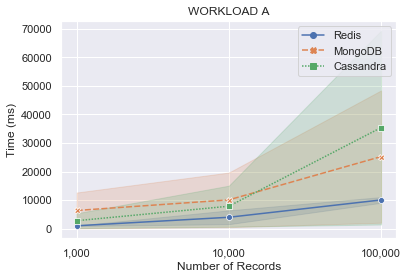

In [8]:
workload = 'workload a'
renderGraph(db, workload)

In [12]:
# show all run for each database
""""
db_name = 'redis'

db = db[db.database==db_name]
dbgraph = sns.lineplot(x=db.record_nbr, 
                       y=db.latency, 
                       hue=db.database,
                       units=db.run, 
                       estimator=None, 
                       lw=1,)

handles, labels = dbgraph.get_legend_handles_labels()
dbgraph.legend(handles=handles[1:], labels=labels[1:])
dbgraph.set(xlabel='Number of Records', ylabel="Time (ms)")
dbgraph.set_title(workload.upper())
dbgraph
"""

'"\ndb_name = \'redis\'\n\ndb = db[db.database==db_name]\ndbgraph = sns.lineplot(x=db.record_nbr, \n                       y=db.latency, \n                       hue=db.database,\n                       units=db.run, \n                       estimator=None, \n                       lw=1,)\n\nhandles, labels = dbgraph.get_legend_handles_labels()\ndbgraph.legend(handles=handles[1:], labels=labels[1:])\ndbgraph.set(xlabel=\'Number of Records\', ylabel="Time (ms)")\ndbgraph.set_title(workload.upper())\ndbgraph\n'

In [7]:
db1 = pd.read_csv("my-data/output.csv")
db1

,run,database,workload,record_nbr,type,label,value
0,r1,Redis,workload a,"1,000",overall,RunTime(ms),1064.000
1,r1,Redis,workload a,"1,000",overall,Throughput(ops/sec),939.840
2,r1,Redis,workload a,"10,000",overall,RunTime(ms),1563.000
3,r1,Redis,workload a,"10,000",overall,Throughput(ops/sec),6397.952
4,r1,Redis,workload a,"100,000",overall,RunTime(ms),9051.000
5,r1,Redis,workload a,"100,000",overall,Throughput(ops/sec),11048.500
6,m1,MongoDB,workload a,"1,000",overall,RunTime(ms),12645.000
7,m1,MongoDB,workload a,"1,000",overall,Throughput(ops/sec),79.080
8,m1,MongoDB,workload a,"10,000",overall,RunTime(ms),19637.000
9,m1,MongoDB,workload a,"10,000",overall,Throughput(ops/sec),509.240


In [14]:
db1.dtypes

run            object
database       object
workload       object
record_nbr     object
type           object
label          object
value         float64
dtype: object

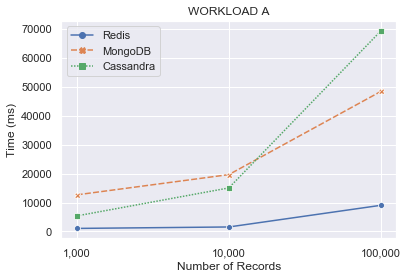

In [45]:
workload = 'workload a'
db1 = db1.query("label=='RunTime(ms)'")
renderGraph(db1, workload)

In [16]:
pwd

'/Users/ghost/src/github/YCSB-scripts/visualization'

## Iterate thru the output folder and get root path

In [50]:
import re

from os import path
from os import walk

path_root = 'output'
path_dbs = []
path_db_workload_files = []

def iterate_database(root_dir):
    db = []
    for database in walk(root_dir):
        db.append(database[1])
   
    #testing 
    db[0] = ['mongodb','redis']
    for database in db[0]:
        path_dbs.append(root_dir + '/' + database)
    #prod
    #for database in db[0]:
        #path_dbs.append(root_dir + '/' + database)

def iterate_file(path_dbs):
    for path_db in path_dbs:
        for root, dirs, files in walk(path_db):  
            for filename in files:
                print(root + '/' + filename)
                #print(filename)
                #TODO check if .txt~
                path_db_workload_files.append(root + '/' + filename)

iterate_database(path_root)
iterate_file(path_dbs)


output/mongodb/100k.load-1.workloada.txt
output/mongodb/10k.load-1.workloada.txt
output/mongodb/1k.load-1.workloada.txt
output/mongodb/workloada/100k.run-1.workloada.txt
output/mongodb/workloada/10k.run-1.workloada.txt
output/mongodb/workloada/1k.run-1.workloada.txt
output/mongodb/workloadb/100k.run-1.workloadb.txt
output/mongodb/workloadb/10k.run-1.workloadb.txt
output/mongodb/workloadb/1k.run-1.workloadb.txt
output/mongodb/workloadc/100k.run-1.workloadc.txt
output/mongodb/workloadc/10k.run-1.workloadc.txt
output/mongodb/workloadc/1k.run-1.workloadc.txt
output/mongodb/workloadd/100k.run-1.workloadd.txt
output/mongodb/workloadd/10k.run-1.workloadd.txt
output/mongodb/workloadd/1k.run-1.workloadd.txt
output/redis/100k.load-1.workloada.txt
output/redis/10k.load-1.workloada.txt
output/redis/1k.load-1.workloada.txt
output/redis/workloada/100k.run-1.workloada.txt
output/redis/workloada/10k.run-1.workloada.txt
output/redis/workloada/1k.run-1.workloada.txt
output/redis/workloadb/100k.run-1.wor

## Read output file and add to dataframe

## Single filename

In [27]:
filename_path = path_db_workload_files[0]
filename = filename_path.split(sep='/')[2]

output = pd.read_csv(filename_path, header=None)
output.head()

,0,1,2
0,[OVERALL],RunTime(ms),19059.000000
1,[OVERALL],Throughput(ops/sec),5246.864998
2,[TOTAL_GCS_PS_Scavenge],Count,55.000000
3,[TOTAL_GC_TIME_PS_Scavenge],Time(ms),46.000000
4,[TOTAL_GC_TIME_%_PS_Scavenge],Time(%),0.241356


## Double file name

In [51]:
df_output =[]
filename_paths = path_db_workload_files
filename_paths

['output/mongodb/100k.load-1.workloada.txt',
 'output/mongodb/10k.load-1.workloada.txt',
 'output/mongodb/1k.load-1.workloada.txt',
 'output/mongodb/workloada/100k.run-1.workloada.txt',
 'output/mongodb/workloada/10k.run-1.workloada.txt',
 'output/mongodb/workloada/1k.run-1.workloada.txt',
 'output/mongodb/workloadb/100k.run-1.workloadb.txt',
 'output/mongodb/workloadb/10k.run-1.workloadb.txt',
 'output/mongodb/workloadb/1k.run-1.workloadb.txt',
 'output/mongodb/workloadc/100k.run-1.workloadc.txt',
 'output/mongodb/workloadc/10k.run-1.workloadc.txt',
 'output/mongodb/workloadc/1k.run-1.workloadc.txt',
 'output/mongodb/workloadd/100k.run-1.workloadd.txt',
 'output/mongodb/workloadd/10k.run-1.workloadd.txt',
 'output/mongodb/workloadd/1k.run-1.workloadd.txt',
 'output/redis/100k.load-1.workloada.txt',
 'output/redis/10k.load-1.workloada.txt',
 'output/redis/1k.load-1.workloada.txt',
 'output/redis/workloada/100k.run-1.workloada.txt',
 'output/redis/workloada/10k.run-1.workloada.txt',
 'o

## Set dataframe values

In [36]:
def set_type():
    task_type = output.loc[0][0]
    return task_type[1:-1]

def set_label():
    task_label = output.loc[0][1].lstrip()
    return task_label

def set_value():
    seconds =  float(output.loc[0][2])
    return seconds
    
def set_database():
    database_name = filename_path.split(sep='/')[1].title()
    return database_name

def set_record_nbr():
    record_nbr = ''
    col_record = filename.split(sep='.')[0]
    
    if(col_record=='1k'):
        record_nbr='1,000'
    elif(col_record=='10k'):
        record_nbr='10,000'
    elif(col_record=='100k'):
        record_nbr='100,000'
    else:
        record_nbr='1,000,000'
    
    return record_nbr

def set_run():
    col_run = filename.split(sep='.')[1]
    return col_run

def set_workload():
    col_workload = filename.split(sep='.')[2]
    
    w_type = col_workload[len(col_workload)-1]
    w_base = col_workload[:-1]

    workload_name = w_base + ' ' + w_type
    
    return workload_name

def set_data_row():
    output_data = {}
    output_data['run'] = set_run()
    output_data['database'] = set_database()
    output_data['workload'] = set_workload()
    output_data['record_nbr'] = set_record_nbr()
    output_data['type'] = set_type()
    output_data['label'] = set_label()
    output_data['value'] = set_value()

    return output_data

In [52]:
for filename_path in filename_paths:
    file = filename_path.split(sep='/')
    filename = (file[len(file)-1])
    print(filename_path)
    output = pd.read_csv(filename_path, header=None)
    
    df_output.append(set_data_row())

output/mongodb/100k.load-1.workloada.txt
output/mongodb/10k.load-1.workloada.txt
output/mongodb/1k.load-1.workloada.txt
output/mongodb/workloada/100k.run-1.workloada.txt
output/mongodb/workloada/10k.run-1.workloada.txt
output/mongodb/workloada/1k.run-1.workloada.txt
output/mongodb/workloadb/100k.run-1.workloadb.txt
output/mongodb/workloadb/10k.run-1.workloadb.txt
output/mongodb/workloadb/1k.run-1.workloadb.txt
output/mongodb/workloadc/100k.run-1.workloadc.txt
output/mongodb/workloadc/10k.run-1.workloadc.txt
output/mongodb/workloadc/1k.run-1.workloadc.txt
output/mongodb/workloadd/100k.run-1.workloadd.txt
output/mongodb/workloadd/10k.run-1.workloadd.txt
output/mongodb/workloadd/1k.run-1.workloadd.txt
output/redis/100k.load-1.workloada.txt
output/redis/10k.load-1.workloada.txt
output/redis/1k.load-1.workloada.txt
output/redis/workloada/100k.run-1.workloada.txt
output/redis/workloada/10k.run-1.workloada.txt
output/redis/workloada/1k.run-1.workloada.txt
output/redis/workloadb/100k.run-1.wor

In [53]:
db3 = pd.DataFrame(df_output, columns=['run','database','workload','record_nbr','type','label','value'])
db3

,run,database,workload,record_nbr,type,label,value
0,load-1,Mongodb,workload a,"100,000",OVERALL,RunTime(ms),43014.0
1,load-1,Mongodb,workload a,"10,000",OVERALL,RunTime(ms),18189.0
2,load-1,Mongodb,workload a,"1,000",OVERALL,RunTime(ms),12448.0
3,run-1,Mongodb,workload a,"100,000",OVERALL,RunTime(ms),48384.0
4,run-1,Mongodb,workload a,"10,000",OVERALL,RunTime(ms),19637.0
5,run-1,Mongodb,workload a,"1,000",OVERALL,RunTime(ms),12645.0
6,run-1,Mongodb,workload b,"100,000",OVERALL,RunTime(ms),46857.0
7,run-1,Mongodb,workload b,"10,000",OVERALL,RunTime(ms),18784.0
8,run-1,Mongodb,workload b,"1,000",OVERALL,RunTime(ms),12126.0
9,run-1,Mongodb,workload c,"100,000",OVERALL,RunTime(ms),43236.0


In [200]:
db1.head(9)

,run,database,workload,record_nbr,type,label,value
0,r1,Redis,workload a,"1,000",overall,RunTime(ms),1064.0
2,r1,Redis,workload a,"10,000",overall,RunTime(ms),1563.0
4,r1,Redis,workload a,"100,000",overall,RunTime(ms),9051.0
6,m1,MongoDB,workload a,"1,000",overall,RunTime(ms),12645.0
8,m1,MongoDB,workload a,"10,000",overall,RunTime(ms),19637.0
10,m1,MongoDB,workload a,"100,000",overall,RunTime(ms),48384.0
12,cs1,Cassandra,workload a,"1,000",overall,RunTime(ms),5374.0
14,cs1,Cassandra,workload a,"10,000",overall,RunTime(ms),15042.0
16,cs1,Cassandra,workload a,"100,000",overall,RunTime(ms),69294.0


In [216]:
db1.query("label=='RunTime(ms)'").head()

,run,database,workload,record_nbr,type,label,value
0,r1,Redis,workload a,"1,000",overall,RunTime(ms),1064.0
2,r1,Redis,workload a,"10,000",overall,RunTime(ms),1563.0
4,r1,Redis,workload a,"100,000",overall,RunTime(ms),9051.0
6,m1,MongoDB,workload a,"1,000",overall,RunTime(ms),12645.0
8,m1,MongoDB,workload a,"10,000",overall,RunTime(ms),19637.0


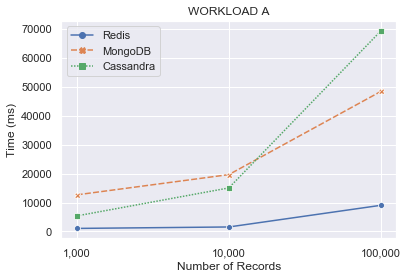

In [243]:
workload = 'workload a'
db1.query("label=='RunTime(ms)'")
renderGraph(db1, workload)

/Users/ghost/src/virtual_env/jupyther3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


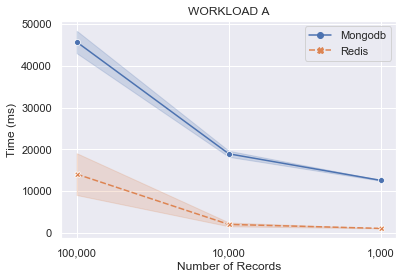

In [54]:
workload = 'workload a'
db3.sort_values(by=['workload','record_nbr']).query("workload=='workload a'")
renderGraph(db3, workload)